# Toward Faster than root n rates 

### Benjamin Cohen, Arthur Gourrin, Hugues René-Bazin, Julien Toucheboeuf 

In [21]:
import numpy as np
import random
from scipy.special import legendre
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import MultiTaskLassoCV

In [22]:
d = 1

In [23]:
def g(x):
    return x

def f(x):
    m1 = np.array([-1]*d)
    m2 = np.array([1]*d)
    
    f1 = 1/np.sqrt((2*np.pi)**d)*np.exp(-1/2*np.dot(np.transpose(x-m1), x-m1))
    f2 = 1/np.sqrt((2*np.pi)**d)*np.exp(-1/2*np.dot(np.transpose(x-m2), x-m2))
    
    return 1/2*f1 + 1/2*f2

def q(x, theta):
    m1 = np.array([-1-theta]*d)
    m2 = np.array([1+theta]*d)
    
    q1 = 1/np.sqrt((2*np.pi)**d)*np.exp(-1/2*np.dot(np.transpose(x-m1), x-m1))
    q2 = 1/np.sqrt((2*np.pi)**d)*np.exp(-1/2*np.dot(np.transpose(x-m2), x-m2))
    
    return 1/2*q1 + 1/2*q2

In [24]:
def samples(num_points, theta):
    m1 = np.array([-1-theta]*d)
    m2 = np.array([1+theta]*d)
    G = np.identity(d)

    if num_points%2 == 0:
        X1 = np.random.multivariate_normal(m1, G, num_points//2)
        X2 = np.random.multivariate_normal(m2, G, num_points//2)
    else:
        X1 = np.random.multivariate_normal(m1, G, num_points//2+1)
        X2 = np.random.multivariate_normal(m2, G, num_points//2)

    return np.concatenate((X1, X2), axis=0)

def MC_basic(theta=0.1, num_points=100):
    X = samples(num_points, theta)
    Y = [g(X[i])*f(X[i])/q(X[i], theta) for i in range(num_points)]

    return np.sum(Y)/num_points

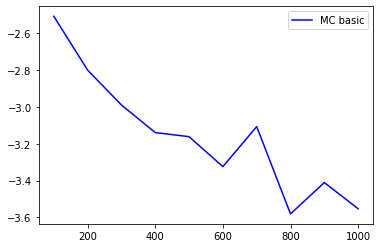

In [25]:
def draw_MC_basic():
    absc = np.arange(100, 1100, 100)
    ordo = []

    for x in absc:
        result = np.mean([np.log10(MC_basic(theta=0.01, num_points=x)**2) for _ in range(50)])
        ordo.append(result)

    plt.plot(absc, ordo, color='blue', label='MC basic')

    return

draw_MC_basic()
plt.legend()
plt.show()

In [26]:
def samples_Legendre(theta, num_points):
    X = []

    for i in range(num_points):
        x = random.gauss(theta, 1)
        while (abs(x) > 1):
            x = random.gauss(theta, 1)
        X.append(x)
    
    return X

def MC_Legendre(theta=0.1, num_points=100, num_covariates=10):
    
    def f(x): #Gaussian N(0, 1)
        return 1/np.sqrt(2*np.pi)*np.exp(-x**2/2)

    def q(x, theta): #Gaussian N(theta, 1)
        return 1/np.sqrt(2*np.pi)*np.exp(-(x-theta)**2/2)
    
    X = samples_Legendre(theta, num_points)
    Y = [g(X[i])*f(X[i])/q(X[i], theta) for i in range(num_points)]
    Z = np.zeros((num_points, num_covariates))

    for k in range(num_covariates):
        Z[:, k] = [np.polyval(legendre(k), X[i])/q(X[i], theta) for i in range(num_points)]
    
    for k in range(num_covariates):
        Z[:, k] = Z[:, k] - np.mean(Z[:, k])

    betas = np.linalg.solve(np.dot(np.transpose(Z), Z), np.dot(np.transpose(Z), Y))

    correction = 0
    for i in range(num_points):
        correction += np.sum([betas[k]*Z[i, k]])/num_points
    
    return np.sum(Y)/num_points - correction

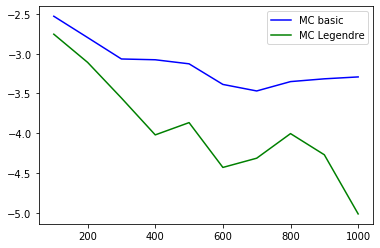

In [27]:
def draw_MC_Legendre():
    absc = np.arange(100, 1100, 100)
    ordo = []

    for x in absc:
        result = np.mean([np.log10(MC_Legendre(theta=0.01, num_points=x, num_covariates=10)**2) for _ in range(5)])
        ordo.append(result)

    plt.plot(absc, ordo, color='green', label='MC Legendre')

    return

draw_MC_basic()
draw_MC_Legendre()
plt.legend()
plt.show()

In [28]:
def MC_Legendre_sklearn(theta=0.1, num_points=100, num_covariates=10):

    def f(x): #Gaussian N(0, 1)
        return 1/np.sqrt(2*np.pi)*np.exp(-x**2/2)

    def q(x, theta): #Gaussian N(theta, 1)
        return 1/np.sqrt(2*np.pi)*np.exp(-(x-theta)**2/2)

    X = samples_Legendre(theta, num_points)
    Y = [g(X[i])*f(X[i])/q(X[i], theta) for i in range(num_points)]
    Z = np.zeros((num_points, num_covariates))

    for k in range(num_covariates):
        Z[:, k] = [np.polyval(legendre(k), X[i])/q(X[i], theta) for i in range(num_points)]

    for k in range(num_covariates):
        Z[:, k] = Z[:, k] - np.mean(Z[:, k])

    reg = LinearRegression().fit(Z, Y)
    betas = reg.coef_

    correction = 0
    for i in range(num_points):
        correction += np.sum([betas[k]*Z[i, k]])/num_points
    
    return np.sum(Y)/num_points - correction

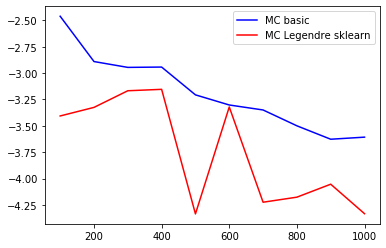

In [29]:
def draw_MC_Legendre_sklearn():
    absc = np.arange(100, 1100, 100)
    ordo = []

    for x in absc:
        result = np.mean([np.log10(MC_Legendre_sklearn(theta=0.01, num_points=x, num_covariates=10)**2) for _ in range(5)])
        ordo.append(result)

    plt.plot(absc, ordo, color='red', label='MC Legendre sklearn')

    return

draw_MC_basic()
draw_MC_Legendre_sklearn()
plt.legend()
plt.show()

In [30]:
def MC_kernel(theta=0.1, num_points=100, num_covariates=10, h_kernel=0.1):
    X = samples(num_points, theta)
    Y = [g(X[i])*f(X[i])/q(X[i], theta) for i in range(num_points)]
    Z = np.zeros((num_points, num_covariates))

    def K(h, x):
        m = [0]*d 
        return 1/h*1/np.sqrt((2*np.pi)**d)*np.exp(-1/2*np.dot(np.transpose(x/h-m), x/h-m))

    for k in range(num_covariates):
        Z[:, k] = [K(h_kernel, X[i] - X[k])/q(X[i], theta) - 1 for i in range(num_points)]

    for k in range(num_covariates):
        Z[:, k] = Z[:, k] - np.mean(Z[:, k])

    reg = LinearRegression().fit(Z, Y)
    betas = reg.coef_

    correction = np.sum(np.sum(np.dot(Z, np.transpose(betas))))/(num_covariates*num_points)
    
    return np.sum(Y)/num_points - correction

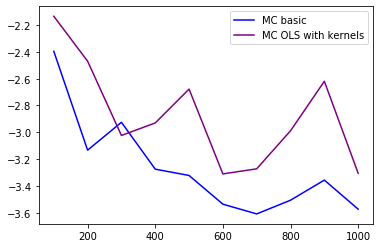

In [31]:
def draw_MC_kernel():
    absc = np.arange(100, 1100, 100)
    ordo = []

    for x in absc:
        result = np.mean([np.log10(MC_kernel(theta=0.01, num_points=x, num_covariates=30, h_kernel=0.01)**2) for _ in range(5)])
        ordo.append(result)

    plt.plot(absc, ordo, color='purple', label='MC OLS with kernels')

    return

draw_MC_basic()
draw_MC_kernel()
plt.legend()
plt.show()

In [32]:
def MC_kernel_Lasso(theta=0.1, num_points=100, num_covariates=10, h_kernel=0.1):
    X = samples(num_points, theta)
    Y = [g(X[i])*f(X[i])/q(X[i], theta) for i in range(num_points)]
    Z = np.zeros((num_points, num_covariates))

    def K(h, x):
        m = [0]*d 
        return 1/h*1/np.sqrt((2*np.pi)**d)*np.exp(-1/2*np.dot(np.transpose(x/h-m), x/h-m))

    for k in range(num_covariates):
        Z[:, k] = [K(h_kernel, X[i] - X[k])/q(X[i], theta) - 1 for i in range(num_points)]

    for k in range(num_covariates):
        Z[:, k] = Z[:, k] - np.mean(Z[:, k])

    reg = MultiTaskLassoCV(alphas=[0.1]).fit(Z, Y)
    betas = reg.coef_

    correction = np.sum(np.sum(np.dot(Z, np.transpose(betas))))/(num_covariates*num_points)
    
    return np.sum(Y)/num_points - correction

/home/arthur/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:463: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01688964836591822, tolerance: 0.014803730422213952
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random)


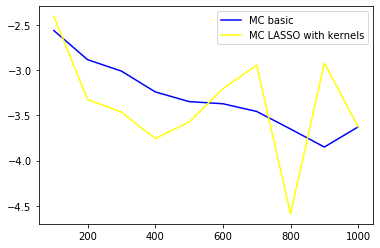

In [33]:
def draw_MC_kernel_Lasso():
    absc = np.arange(100, 1100, 100)
    ordo = []

    ordo = [np.mean([np.log10(MC_kernel_Lasso(theta=0.01, num_points=x, num_covariates=30, h_kernel=0.01)**2) for _ in range(5)]) for x in absc]

    plt.plot(absc, ordo, color='yellow', label='MC LASSO with kernels')

    return

draw_MC_basic()
draw_MC_kernel_Lasso()
plt.legend()
plt.show()

In [34]:
def MC_kernel_smoothing(theta=0.1, num_points=100, h_kernel=0.1):
    X = samples(num_points, theta)
    Y = [g(X[i])*f(X[i])/q(X[i], theta) for i in range(num_points)]
    m = np.mean(Y)
    
    def K(h, x):
        m0 = [0]*d
        return 1/h*1/np.sqrt((2*np.pi)**d)*np.exp(-1/2*np.dot(np.transpose(x/h-m0), x/h-m0))

    phi = [Y[j]*K(h_kernel, X[j]) for j in range(num_points)]

    Z = [phi[k]/q(X[k], theta) - m for k in range(num_points)]
    Z = Z - np.mean(Z)

    correction = np.sum(Z)/num_points
    
    return np.sum(Y)/num_points - correction

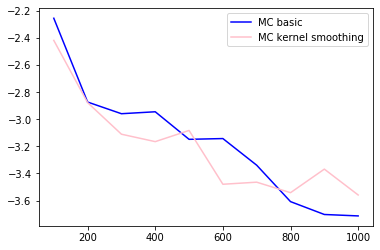

In [35]:
def draw_MC_kernel_smoothing():
    absc = np.arange(100, 1100, 100)
    ordo = []

    for x in absc:
        result = np.mean([np.log10(MC_kernel_smoothing(theta=0.01, num_points=x, h_kernel=0.01)**2) for _ in range(50)])
        ordo.append(result)

    plt.plot(absc, ordo, color='pink', label='MC kernel smoothing')

    return

draw_MC_basic()
draw_MC_kernel_smoothing()
plt.legend()
plt.show()